Bootstrap resampling to determine the confidence intervals of the population.

See the blog at: https://medium.com/p/cca9dc855d1b

In [129]:
# number stuff
import pandas as pd
import numpy as np

# plotting stuff
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import seaborn as sns

#from scipy import stats
# resampling
from sklearn.utils import resample


In [130]:
# Import the data into a Pandas Dataframe
df = pd.read_csv('data/event_2_donations.csv', index_col=0)

## look at  data

In [131]:
# total amount of donations
df.sum()

amount    2312.2
dtype: float64

In [132]:
# 5 point stats 
df.describe()

,amount
count,64.000000
mean,36.128125
std,46.502191
min,10.000000
25%,10.000000
50%,20.000000
75%,42.500000
max,303.000000


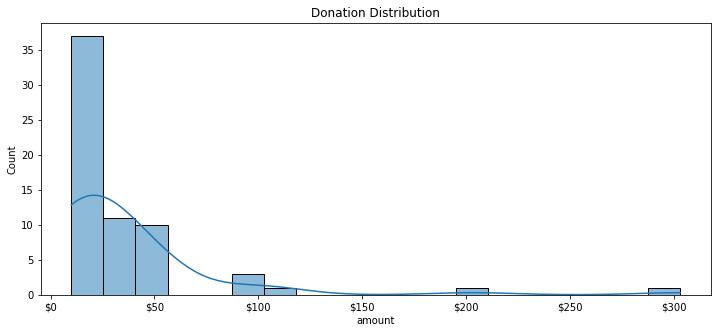

In [146]:
# plot the distribution of the donations

# set the size of the figure
plt.figure(figsize=(12,5))

# plot the histogram
ax = sns.histplot(df.amount, kde=True)

# set the title
plt.title('Donation Distribution')

# format the x axis as # amounts
formatter = ticker.FormatStrFormatter('$%1.0f')
ax.xaxis.set_major_formatter(formatter)

We can see from the 5 point stats that the minimum value for the Amount is 1. So the people who did not donate are not included.  We want to add them into this data as guests who donated zero. Our goal is to determine what the nonprofit can expect based on registrations.  If we don't include those our estimate will be too high.

The first event had 109 people register
The second event had 126 people register

To add those in we want to see the difference between the number of people who registered and the number of donations for that event, and pad the list with zeros for the people who didn't donate.

In [197]:
# count the number of people who did not donate by subtracting the total number
# of donations from the total number of registered attendees 
number_of_cheapskates = 126 - len(df)

# create a dataframe of 0's with length of equal to number_of_cheapskates
cheapskates = pd.DataFrame(np.zeros(number_of_cheapskates), 
                           columns = ['amount'])
cheapskates.head()

,amount
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [198]:
# check that we have the right number of cheapskates
len(cheapskates)

62

In [221]:
# create a new dataframe with all registered attendees and the amount they donated.
df_combined = pd.concat([df, cheapskates])

# get the new mean
sample_mean = df_combined['amount'].mean()
round(sample_mean, 2)

18.35

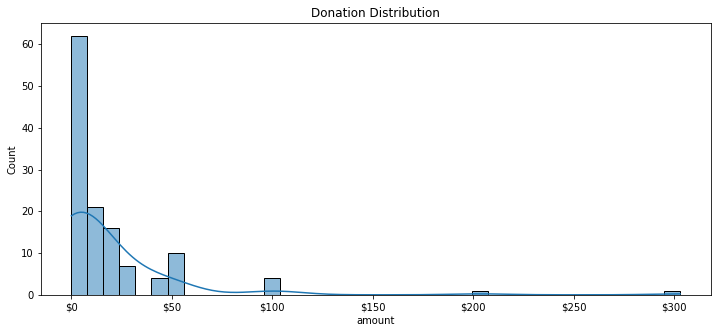

In [200]:
# plot the new distribution of the donations

# set the size of the figure
plt.figure(figsize=(12,5))

# plot the histogram
ax = sns.histplot(df_combined.amount, kde=True)

# set the title
plt.title('Donation Distribution')

# format the x axis as # amounts
formatter = ticker.FormatStrFormatter('$%1.0f')
ax.xaxis.set_major_formatter(formatter)

## Resample to find the population mean and confidence intervals.

Why?  Because we want to know what to expect for other similar events.  By resampling we get an estimator of the sampling variation in the population.  We look at the difference between the resampled mean and our sample mean to get a distribution of the errors which we can use to estimate the confidence intervals for samples of this size from the population.

For a large number of samples it will converge on an estimate of the distribution of the population.  Lets test how this converges

In [227]:
# create an empy list to hold the errors (differences between our ) 
error = []
resample_means = []
for i in range(1000):
    resample_means.append(resample(df_combined.amount).mean())

The mean of the resample_means will be about the same as the mean of our original sample.

In [228]:
print(f'Original Sample Mean: {round(sample_mean, 2)}')
print('Mean of resampled means:', round(np.mean(resample_means), 2))

Original Sample Mean: 18.35
Mean of resampled means: 18.42


In [233]:
# calculate the differences between each of the resampled means
# and our original sample mean

deltas = np.array(resample_means) - sample_mean

In [237]:
# We can either take the quantile range that corresponds to our desired
# confidence interval
np.quantile(deltas, [.025,.975]).round(2)


array([-5.88,  7.55])

In [239]:
# or just order the deltas and take the 25th and 975th element which will be
# aproximatly the same.
deltas.sort()
np.round((deltas[24], deltas[974]),2)

array([-5.88,  7.55])

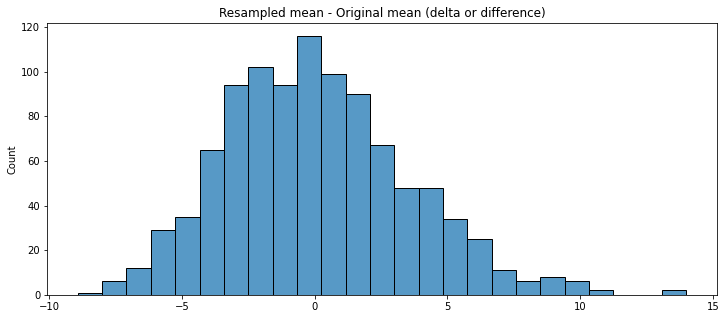

In [240]:
plt.figure(figsize=(12,5))
sns.histplot(error)

plt.title('Resampled mean - Original mean (delta or difference)')

formatter = ticker.FormatStrFormatter('$%1.0f')
ax.xaxis.set_major_formatter(formatter)


Because we are using 1000 samples the quantile should be the same as record 250 and 975 from an ordered dataset.

# Plot convergance of confidence intervals

In [179]:
# Resample event_2_donations
x_bar_star = {}
x_bar = df_combined['amount'].mean()

errors = {}

# try with different resample sizes
for n in np.logspace(1, 3.5, num=50):
#for n in np.linspace(1, 1000):
#for n in range(1, 1000):

    print(n)
    # do the resampling
    for i in range(int(n)):
        mean = resample(df_combined.amount).mean()
        x_bar_star[n] = x_bar_star.get(n, [])
        x_bar_star[n].append(mean)
        
    error = np.array(x_bar_star[n]) - x_bar
    errors[n] = np.quantile(error, [.025,.975])
               
errors

10.0
11.246578221198195
12.648552168552959
14.225293134853699
15.998587196060582
17.992936232915525
20.235896477251575
22.758459260747887
25.59547922699536
28.786155923545685
32.374575428176435
36.410319493106755
40.94915062380425
46.05378255822414
51.794746792312125
58.25136712468927
65.51285568595509
73.6795455966163
82.86427728546842
93.1939576234078
104.81131341546852
117.87686347935866
132.57113655901094
149.09716571840644
167.68329368110082
188.58632787726498
212.09508879201903
238.53440064314213
268.2695795279727
301.71148105292957
339.32217718953297
381.6213407949357
429.1934260128778
482.6957437677871
542.867543932386
610.5402296585327
686.6488450042998
772.2449945836254
868.511373751353
976.7781100894892
1098.5411419875584
1235.482888256747
1389.4954943731375
1562.7069765469948
1757.510624854793
1976.5980717016348
2222.9964825261955
2500.1103826179306
2811.7686979742307
3162.2776601683795


{10.0: array([-2.86380952,  4.51472222]),
 11.246578221198195: array([-6.85     ,  3.2702381]),
 12.648552168552959: array([-4.0802381 ,  8.57365079]),
 14.225293134853699: array([-5.45257937,  4.49777778]),
 15.998587196060582: array([-3.40277778, 10.01230159]),
 17.992936232915525: array([-2.52222222,  5.94507937]),
 20.235896477251575: array([-3.89325397,  6.66130952]),
 22.758459260747887: array([-5.6165873 ,  9.09861111]),
 25.59547922699536: array([-5.95873016,  8.52539683]),
 28.786155923545685: array([-5.9777381 ,  6.24095238]),
 32.374575428176435: array([-3.48103175,  4.93853175]),
 36.410319493106755: array([-5.34047619,  7.37539683]),
 40.94915062380425: array([-4.39924603,  6.90980159]),
 46.05378255822414: array([-4.43055556,  5.93730159]),
 51.794746792312125: array([-4.70992063,  6.94404762]),
 58.25136712468927: array([-5.60781746,  6.05813492]),
 65.51285568595509: array([-5.46761905,  6.02507937]),
 73.6795455966163: array([-6.08730159,  7.35904762]),
 82.86427728546

In [94]:
errors

{10.0: array([-1.93373016,  7.48769841]),
 11.246578221198195: array([-4.91269841,  4.12698413]),
 12.648552168552959: array([-2.3702381 ,  5.49742063]),
 14.225293134853699: array([-4.25496032,  7.70496032]),
 15.998587196060582: array([-5.3452381 ,  3.40833333]),
 17.992936232915525: array([-3.7015873 ,  4.93492063]),
 20.235896477251575: array([-4.93234127,  5.25496032]),
 22.758459260747887: array([-4.08869048,  5.33630952]),
 25.59547922699536: array([-5.22857143,  8.44444444]),
 28.786155923545685: array([-4.4359127 ,  5.68055556]),
 32.374575428176435: array([-4.47559524,  5.31289683]),
 36.410319493106755: array([-5.63492063,  5.88690476]),
 40.94915062380425: array([-4.43928571,  5.26527778]),
 46.05378255822414: array([-4.81845238,  6.42460317]),
 51.794746792312125: array([-5.07142857,  4.87301587]),
 58.25136712468927: array([-5.51428571,  4.7015873 ]),
 65.51285568595509: array([-6.0047619 ,  5.77142857]),
 73.6795455966163: array([-5.50952381,  5.50952381]),
 82.864277285

In [96]:
df_errors = pd.DataFrame.from_dict(errors).T
df_errors.head()

,0,1
10.000000,-1.933730,7.487698
11.246578,-4.912698,4.126984
12.648552,-2.370238,5.497421
14.225293,-4.254960,7.704960
15.998587,-5.345238,3.408333


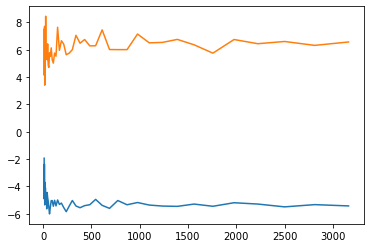

In [98]:
plt.plot(df_errors.index, df_errors[0])
plt.plot(df_errors.index, df_errors[1])


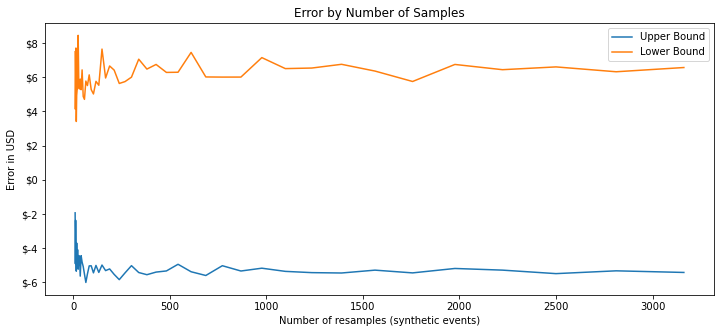

In [188]:



plt.figure(figsize=(12,5))

plt.plot(df_errors.index, df_errors[0], label='Upper Bound')
plt.plot(df_errors.index, df_errors[1], label='Lower Bound')

plt.title('Error by Number of Samples')
plt.ylabel('Error in USD')
plt.xlabel('Number of resamples (synthetic events)')

formatter = ticker.FormatStrFormatter('$%1.0f')

ax = plt.gca()
ax.yaxis.set_major_formatter(formatter)

plt.legend()


In [164]:
len(error)

1000

In [162]:
x_bar = df_combined['amount'].mean()

In [167]:
x_bar + error[10]

10.566666666666663

In [176]:
round(x_bar + error[10], 2)

10.57

References:
https://towardsdatascience.com/a-complete-guide-to-confidence-interval-and-examples-in-python-ff417c5cb593

https://moderndive.com/8-confidence-intervals.html

